# <font color='orange'>1. Import Libraries</font>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# <font color='orange'>2. Helper functions</font> 

In [3]:
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
    plt.show()
    
def rgb2bin(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blured_image = cv2.GaussianBlur(img_gray,(5,5), 1)
    canny_image = cv2.Canny(blured_image, 10, 50)
    t, img_bin = cv2.threshold(
        canny_image, 150, 255,cv2.THRESH_BINARY
    )
    return img_bin

def best_contours(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, h = cv2.findContours(
        img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    best_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return best_contours

def find_contours(original_image, binary_image, index=-1, color=(255, 0, 0), thickness=10):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img_copy = original_image.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)

def get_corner_points(contour):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02* peri, True)
    return approx

# <font color='orange'>3. Read image</font>

In [12]:
image_path = 'images/img5_1.jpg'          # Path of image
width_image = 1000                       # Width of image
height_image = 1000                      # Height of image
questions = 5
choices = 5

answers = [1, 1, 0, 0, 1]

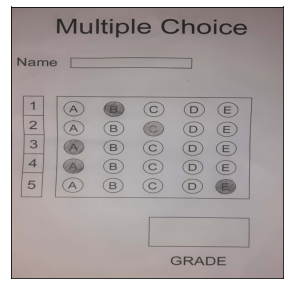

In [18]:
original_image = imread(image_path)          # Read image
resized_image = cv2.resize(original_image,
                           (width_image,height_image))      # Resize image

imshow(resized_image)     # Show original image

# <font color='orange'>4. Preprocessing</font>

- Convert image to binary.
- Find contours

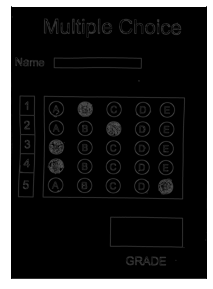

In [13]:
bin_image = rgb2bin(original_image)
imshow(bin_image)

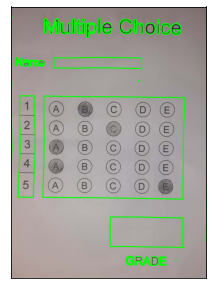

In [14]:
find_contours(original_image, binary_image=bin_image, color=(0, 255, 0))

In [15]:
biggest_contours = best_contours(original_image)
print(f"First contour: {len(biggest_contours[0])}, Second contour: {len(biggest_contours[1])}")

First contour: 5003, Second contour: 2106


In [16]:
answer_contour, grade_contour = get_corner_points(biggest_contours[0]), get_corner_points(biggest_contours[1])
answer_contour, grade_contour

(array([[[ 341,  933]],
 
        [[ 329, 1982]],
 
        [[1777, 2001]],
 
        [[1796,  950]]], dtype=int32),
 array([[[1029, 2187]],
 
        [[1028, 2493]],
 
        [[1776, 2501]],
 
        [[1776, 2197]]], dtype=int32))

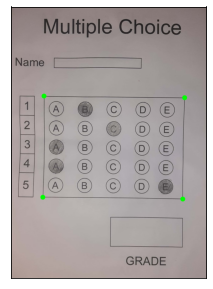

**************************************************


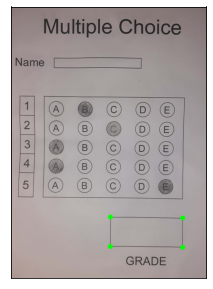

In [17]:
copy_image_for_answer = original_image.copy() 
imshow(cv2.drawContours(copy_image_for_answer, answer_contour, -1, (0, 255,0), 50))
print('*'*50)
copy_image_for_grade = original_image.copy() 
imshow(cv2.drawContours(copy_image_for_grade, grade_contour, -1, (0, 255,0), 50))

## Reorder function
- This function used for reordering each point to know which point is orgin and which is top left and so on.

In [12]:
answer_contour.shape

(4, 1, 2)

-> as we show ths shape is (4, 1, 2) which means that there is `4 rows` each row has `2 columns`, we don't need to 1.

we must reshape this to (4, 2)

In [18]:
def reorderPoints(points):
    points = points.reshape((4,2))
    new_points = np.zeros((4,1,2), np.int32)
    summation = points.sum(1)
    # print(points)
    print(summation)
    new_points[0] = points[np.argmin(summation)]    # [0, 0]
    new_points[3] = points[np.argmax(summation)]    # [w, h]
    different = np.diff(points, axis=1)
    new_points[1] = points[np.argmin(different)]    # [w, 0]
    new_points[2] = points[np.argmax(different)]    # [0, h]
    # print(different)
    return new_points


In [19]:
answer_contour, grade_contour = reorderPoints(answer_contour), reorderPoints(grade_contour)
answer_contour, grade_contour

[1274 2311 3778 2746]
[3216 3521 4277 3973]


(array([[[ 341,  933]],
 
        [[1796,  950]],
 
        [[ 329, 1982]],
 
        [[1777, 2001]]]),
 array([[[1029, 2187]],
 
        [[1776, 2197]],
 
        [[1028, 2493]],
 
        [[1776, 2501]]]))

# <font color='orange'>5. Extract answer part </font>

## find answer part from an image by using coordinates 
- First, must get 2 points and make matrix 

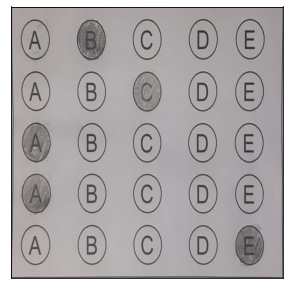

In [20]:
point_answer1 = np.float32(answer_contour) # Point for source image
point_answer2 = np.float32([[0, 0], [width_image, 0], [0, height_image], [width_image, height_image]]) # Point for destination 

matrix_answer = cv2.getPerspectiveTransform(point_answer1, point_answer2) # Matrix that map source image to destination image
image_answer_display = cv2.warpPerspective(original_image, matrix_answer,(width_image, height_image)) # applies the perspective transformation to the original image using the computed transformation matrix
imshow(image_answer_display)

## Now, find grade part from an image by using coordinates 

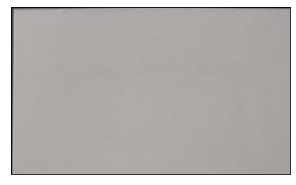

In [21]:
point_grade1 = np.float32(grade_contour)
point_grade2 = np.float32([[0, 0], [400, 0], [0, 200], [400, 200]])

matrix_grade = cv2.getPerspectiveTransform(point_grade1, point_grade2)
image_grade_display = cv2.warpPerspective(original_image, matrix_grade,(300, 180))
imshow(image_grade_display)

# <font color='orange'>6. Check answer</font>

- At first, we must get threshold of an image 

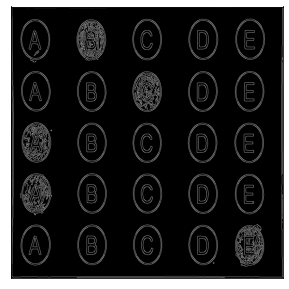

In [22]:
image_answer_bin = rgb2bin(image_answer_display)
imshow(image_answer_bin)

+ Now, i need to crop each letter from this image

In [23]:
image_answer_bin.shape

(1000, 1000)

In [24]:
def split_letters(image_answer):
    letters = []
    rows = image_answer.shape[0]
    multiple = (rows + questions - 1) // questions * questions

    # Resize the image to have a number of rows that is divisible by questions
    image_answer_resized = cv2.resize(image_answer, (image_answer.shape[1], multiple))

    # Split the resized image into rows
    rows = np.vsplit(image_answer_resized, questions)
    # imshow(rows[0])     # To show Row

    for row in rows:
        cols = np.hsplit(row, choices)
        for col in cols:
            letters.append(col)
    return letters


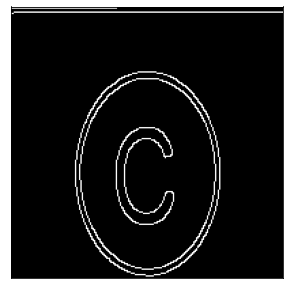

In [31]:
letters = split_letters(image_answer_bin)
imshow(letters[2])

How i now marked image 
1. from binary image i count number of non zero values.
2. if this answer is marked so it has a high of non zero values, because it white.

Show this example

In [32]:
cv2.countNonZero(letters[0]), cv2.countNonZero(letters[1])

(2008, 3903)

From these result 
- letter[0] `A` is not marked.
- letter[1] `B` is marked.


In [33]:
# Now i create array with the same size of an image

new_image_value = np.zeros((questions, choices))
row_counter = 0
column_counter = 0

for letter in letters:
    value_pixel = cv2.countNonZero(letter)

    new_image_value[row_counter, column_counter] = value_pixel
    column_counter += 1
    if column_counter == choices : row_counter +=1 ; column_counter = 0

print(new_image_value)

[[2008. 3903. 1508. 1538. 1743.]
 [1613. 1267. 3184. 1244. 1595.]
 [3437. 1246. 1195. 1230. 1604.]
 [3481. 1256. 1209. 1236. 1512.]
 [1754. 1632. 1613. 1644. 3630.]]


Now, i need to find index of each maximum value

In [34]:
answer_index = []

for x in range(0, questions):
    temp = new_image_value[x]
    index_value = np.where(temp == np.amax(temp))
    # print(index_value[0][0])
    answer_index.append(index_value[0][0])

answer_index

[1, 2, 0, 0, 4]

# <font color='orange'>7. Grading</font>

In [35]:
grading = []

for x in range(0, questions):
    if answers[x] == answer_index[x]:
        grading.append(1)
    else: 
        grading.append(0)

grading

[1, 0, 1, 1, 0]

In [36]:
final_score = (sum(grading) / questions) * 100
final_score

60.0

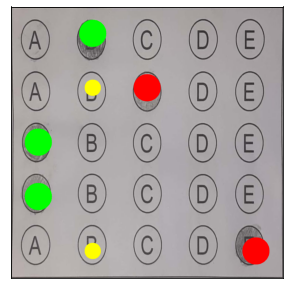

In [59]:
def show_answers(image, answer_index, grading, answers, questions, choices):
    width_sec = int(image.shape[1] / choices)  
    height_sec = int(image.shape[0] / questions)

    for x in range(0, questions):
        my_answer = answer_index[x]
        cx = (my_answer * width_sec) + width_sec //2
        cy = (x * height_sec) + height_sec //2

        if grading[x] == 1:
            my_color = (0, 255, 0)
        else:
            my_color = (255, 0, 0)
            correct_answer = answers[x]
            cv2.circle(image, ((correct_answer * width_sec) + width_sec // 2, (x * height_sec) + height_sec // 2), 30,
                       (255, 255, 0), cv2.FILLED)
        cv2.circle(image, (cx, cy), 50, my_color, cv2.FILLED)
    return image

image_result = image_answer_display.copy()
image_result = show_answers(image_result, answer_index, grading, answers, questions, choices)
imshow(image_result)

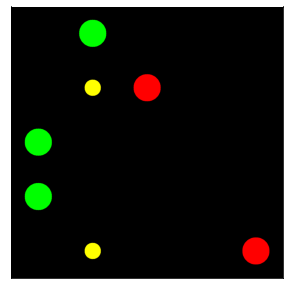

In [60]:
image_row_drawing = np.zeros_like(image_result)
image_row_drawing = show_answers(image_row_drawing, answer_index, grading, answers, questions, choices)
imshow(image_row_drawing)

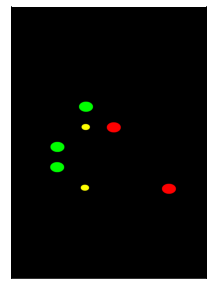

In [61]:
# Invert the perspective transformation matrix
inverse_matrix_answer = np.linalg.inv(matrix_answer)

# Apply the inverse perspective transformation to bring the image back to its original position
original_image_restored = cv2.warpPerspective(image_row_drawing, inverse_matrix_answer, (original_image.shape[1], original_image.shape[0]))
imshow(original_image_restored)

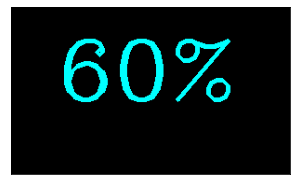

In [71]:
image_row_grading = np.zeros_like(image_grade_display)
cv2.putText(image_row_grading, str(int(final_score)) + '%', (50, 100), cv2.FONT_HERSHEY_COMPLEX, 3, (0, 255, 255), 3)

imshow(image_row_grading)

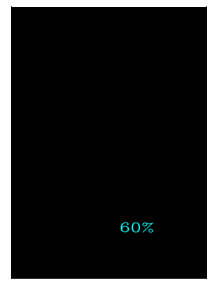

In [63]:
# Invert the perspective transformation matrix
inverse_matrix_grade = np.linalg.inv(matrix_grade)

# Apply the inverse perspective transformation to bring the image back to its original position
original_grade_restored = cv2.warpPerspective(image_row_grading, inverse_matrix_grade, (original_image.shape[1], original_image.shape[0]))
imshow(original_grade_restored)

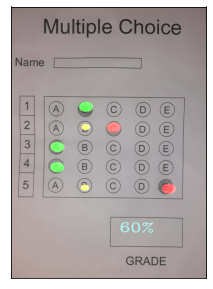

In [69]:
final_image = original_image.copy()

final_image = cv2.addWeighted(final_image,1, original_image_restored, 1, 0)
final_image = cv2.addWeighted(final_image,1, original_grade_restored, 1, 0)
imshow(final_image)